# 1  Problem Statement

If they are more likely to be controlled the more frequent they visit and if that changes based on patient demographics like with insurance without insurance etc
We generally tell diabetics every 3 months want to see if that makes a difference with diabetes and last office visit and control vs. uncontrolled numbers. 


1.       PatientID repeats because they have more than one visit date and more than one date when their a1c was recorded.

2.       Summary = Document or office visit summary associated with the visit. I don’t know if that would be a HIPPA violation, but there is no patient information on the summary so I am guessing it should be good.

3.       VisitDate , summary, date of a1c  has repeated values because the date when a1c was recorded and the visit date are not necessarily the same and patient has different visit dates and different date of a1c, basically its two data sets one would be patientid, summary and visit and the other would be Patientid, date of a1c and a1c_value, Combining those two will create duplicates.

1. Are patients more likely to have a lower/controlled A1c if they have visited more frequently? 
2. NLP on summary: words like poor/worse 
3. Can we predict based off of frequency of visits or last visit, what the patients A1c is? 
- people who come in more frequently, more inclined to have lower levels 
- controlled randomised experiment 

# Imports

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,Ridge, Lasso,LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
df=pd.read_csv("../data/A1c_Data_Requesta1c.csv")
#with insurance

In [3]:
df.head()

,PatientId,Age,Birthdate,VisitDate,SUMMARY,OBSDATE,Date of A1c,Insurance
0,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",7/21/2017 17:21:00,8.1,Dental Sliding Fee
1,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",7/21/2017 17:21:00,8.1,Sliding Fee Scale
2,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",1/19/2019 0:01:15,7.6,Dental Sliding Fee
3,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",1/19/2019 0:01:15,7.6,Sliding Fee Scale
4,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",2/8/2018 19:50:00,8.3,Dental Sliding Fee


# Cleaning and EDA

- Discovered 1,099 patients to look at
-Changed column names
-Changed object type to integer for a1c levels 
-Removed 1.7 a1c
-Changed .089 to 8.9 -- assume an error, 8.9 also the mean value 
-Change date object to datetime 
-drop index 

Moving forward
- group a1c into 8 and below= controlled
- 9 and above = uncontrolled
- add as another column and save into csv 
- You can ignore it and assumed that the visit date is the same as the day they get their A1c- inconsistent 
- group a few patients of different age groups and export to CVS to do EDA 


In [4]:
#Check number of patients by ID
df["PatientId"].value_counts()

115425    6072
971       5880
386       5247
111755    4422
201709    3410
          ... 
234272       2
241167       2
233853       1
234976       1
233208       1
Name: PatientId, Length: 1099, dtype: int64

In [5]:
#change column names 
df.rename(columns={"PatientId": "patient_id","Age": "age", "VisitDate": "visit_date", "SUMMARY":"summary","OBSDATE":"obs_date","Date of A1c":"a1c","Insurance":"insurance"},inplace=True)

In [1]:
df.tail()

NameError: name 'df' is not defined

In [7]:
df.shape

(273485, 8)

In [8]:
df.dtypes

patient_id      int64
age             int64
Birthdate      object
visit_date     object
summary        object
obs_date       object
a1c           float64
insurance      object
dtype: object

In [9]:
df.isnull().sum()

patient_id      0
age             0
Birthdate       0
visit_date      0
summary       218
obs_date        0
a1c            32
insurance       0
dtype: int64

In [10]:
#drop columns with no a1c level 
df.dropna(subset=["a1c"],inplace=True)

In [11]:
df.reset_index(inplace=True)

In [12]:
df.isnull().sum()

index           0
patient_id      0
age             0
Birthdate       0
visit_date      0
summary       218
obs_date        0
a1c             0
insurance       0
dtype: int64

In [281]:
#convert object to float 
def convert(a1c_obj):
    a1c_num=float(a1c_obj)
    return a1c_num

In [14]:
df["a1c"].map(convert)

0          8.1
1          8.1
2          7.6
3          7.6
4          8.3
          ... 
273448    13.4
273449    13.4
273450    12.2
273451    12.2
273452    13.4
Name: a1c, Length: 273453, dtype: float64

In [15]:
df["a1c"].sort_values(ascending=True)
#discovered .089 too low

204598     0.089
204659     0.089
204658     0.089
204651     0.089
204650     0.089
           ...  
268928    19.700
268929    19.700
268930    19.700
268931    19.700
268927    19.700
Name: a1c, Length: 273453, dtype: float64

In [16]:
df["a1c"].max()

19.7

In [17]:
df["a1c"].min()
#this minimum is too low, assume this was meant to be 8.9, which is the mean of the dataset 

0.08900000000000001

In [18]:
df["a1c"].describe()

count    273453.000000
mean          8.902426
std           1.760240
min           0.089000
25%           7.500000
50%           8.400000
75%           9.900000
max          19.700000
Name: a1c, dtype: float64

In [19]:
mask_1= df["a1c"]== 0.08900000000000001
#instead of deleting, change to 8.9

In [20]:
df["a1c"].where(df["a1c"]!= 0.08900000000000001, 8.9,inplace=True)

In [21]:
mask_2= df["a1c"]== 1.7

In [22]:
mask_2.value_counts()

False    272901
True        552
Name: a1c, dtype: int64

In [23]:
#delete values that don't make sense in df
def to_del(value_to_delete):
    to_del_array=[]
    for i in range(len(value_to_delete)):
        if value_to_delete[i]== True: 
            to_del_array.append(i)
    df.drop(to_del_array,inplace=True)
    df.reset_index(drop=True,inplace=True)

In [24]:
to_del(mask_2)

In [25]:
df.shape

(272901, 9)

In [26]:
df["a1c"].min()

7.0

In [27]:
df["insurance"].value_counts()

Sliding Fee Scale                                62917
Medicaid - Husky D                               28659
Medicaid - Husky C                               24322
DO NOT USE - Medicaid State of CT                23376
National Government Services                     21913
Dental Sliding Fee                               17748
Medicaid - Husky A                               15554
Connecticare Exchange                             6944
DO NOT USE-Community Health Network - Husky A     6363
Medicaid State of CT                              6318
DO NOT USE - CHN Saga- Medicaid LIA               6174
Anthem Medicare                                   5742
United Healthcare Medicare                        4564
Connecticare                                      4546
CT Behavioral Health Partnership                  4216
Anthem BCBS                                       4010
Aetna Commercial                                  2675
Aetna Medicare -HMO                               2657
CT Dental 

In [28]:
df['visit_date'] = pd.to_datetime(df['visit_date'])
#change to datetime

In [29]:
df['obs_date'] = pd.to_datetime(df['obs_date'])

In [30]:
df['obs_date']=df['obs_date'].dt.date

In [31]:
df['visit_date']= df['visit_date'].dt.date

In [32]:
df['visit_date'] = pd.to_datetime(df['visit_date'])

In [33]:
df['obs_date'] = pd.to_datetime(df['obs_date'])

In [34]:
df.dtypes

index                  int64
patient_id             int64
age                    int64
Birthdate             object
visit_date    datetime64[ns]
summary               object
obs_date      datetime64[ns]
a1c                  float64
insurance             object
dtype: object

In [35]:
df.shape

(272901, 9)

In [36]:
df.drop_duplicates(inplace=True)

In [37]:
df_no_ins= df.drop(columns=["insurance","Birthdate"])
#drop insurance column for now for EDA. This way we can also drop the duplicates we have because of the insurance section 

In [38]:
df_no_ins['obs_date'] = df_no_ins['obs_date'].dt.date
df_no_ins['visit_date'] = df_no_ins['visit_date'].dt.date

In [39]:
df_no_ins.head()

,index,patient_id,age,visit_date,summary,obs_date,a1c
0,0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1
1,1,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1
2,2,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6
3,3,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6
4,4,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3


In [40]:
df_no_ins.drop(columns=["index"],inplace=True)

In [41]:
df_no_ins.drop_duplicates(inplace=True)

In [45]:
df_no_ins.reset_index(drop=True,inplace=True)

In [46]:
df_no_ins.head()

,patient_id,age,visit_date,summary,obs_date,a1c
0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1
1,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6
2,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3
3,72,56,2017-07-19,"followup diabetes, med refill",2017-10-20,7.7
4,72,56,2017-07-19,"followup diabetes, med refill",2019-06-08,7.1


In [47]:
#create a column that describes patient as being controlled(1) or uncontrolled (0)
df_no_ins["a1c_level"]=""

for i in range(df_no_ins.shape[0]):
    if df_no_ins["a1c"][i] <=8:
        df_no_ins["a1c_level"][i]= 1
    else: df_no_ins["a1c_level"][i]=0
        #1 is controlled
        #0 is uncontrolled 
        

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
df_no_ins.columns

Index(['patient_id', 'age', 'visit_date', 'summary', 'obs_date', 'a1c',
       'a1c_level'],
      dtype='object')

In [49]:
np.unique(df_no_ins["patient_id"].values)

array([    72,    254,    255, ..., 243548, 243642, 243644])

In [50]:
df_no_ins.dtypes

patient_id      int64
age             int64
visit_date     object
summary        object
obs_date       object
a1c           float64
a1c_level      object
dtype: object

In [51]:
df_no_ins.to_csv("../data/cleaned_data.csv")

In [52]:
new_data= pd.read_csv("../data/cleaned_data.csv")

In [53]:
new_data.drop(columns=["Unnamed: 0"],inplace=True)

VisitDate , summary, date of a1c has repeated values because the date when a1c was recorded and the visit date are not necessarily the same and patient has different visit dates and different date of a1c, basically its two data sets one would be patientid, summary and visit and the other would be Patientid, date of a1c and a1c_value, Combining those two will create duplicates.

In [54]:
new_data.dtypes

patient_id      int64
age             int64
visit_date     object
summary        object
obs_date       object
a1c           float64
a1c_level       int64
dtype: object

In [55]:
new_data['visit_date'] = pd.to_datetime(new_data['visit_date'])

In [56]:
new_data['obs_date'] = pd.to_datetime(new_data['obs_date'])

In [57]:
new_data.head()

,patient_id,age,visit_date,summary,obs_date,a1c,a1c_level
0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1,0
1,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6,1
2,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3,0
3,72,56,2017-07-19,"followup diabetes, med refill",2017-10-20,7.7,1
4,72,56,2017-07-19,"followup diabetes, med refill",2019-06-08,7.1,1


In [58]:
#count the number of times they got their bloodwork done
new_data["num_obs"]=""

for i in range(new_data.shape[0]):
    try:
        mas=new_data.loc[new_data['patient_id'] == new_data['patient_id'][i]]
        new_data["num_obs"][i]= mas['obs_date'].nunique()
    except: 
        continue 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
#count the number of visits 
new_data["num_visits"]=""

for i in range(new_data.shape[0]):
    try:
        mas=new_data.loc[new_data['patient_id'] == new_data['patient_id'][i]]
        new_data["num_visits"][i]= mas["visit_date"].nunique()
    except: 
        continue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
summary_and_visit_df = new_data[['patient_id', 'age', 'visit_date','summary',"num_visits"]].copy()
date_a1c_df= new_data[['patient_id', 'age', 'obs_date','a1c','a1c_level',"num_obs"]].copy()

In [61]:
summary_and_visit_df.head()

,patient_id,age,visit_date,summary,num_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10
1,72,56,2017-07-19,"followup diabetes, med refill",10
2,72,56,2017-07-19,"followup diabetes, med refill",10
3,72,56,2017-07-19,"followup diabetes, med refill",10
4,72,56,2017-07-19,"followup diabetes, med refill",10


In [62]:
date_a1c_df.head()

,patient_id,age,obs_date,a1c,a1c_level,num_obs
0,72,56,2017-07-21,8.1,0,6
1,72,56,2019-01-19,7.6,1,6
2,72,56,2018-02-08,8.3,0,6
3,72,56,2017-10-20,7.7,1,6
4,72,56,2019-06-08,7.1,1,6


In [63]:
date_a1c_df.shape

(61943, 6)

In [64]:
summary_and_visit_df.shape

(61943, 5)

In [65]:
date_a1c_df.drop_duplicates(inplace=True)


In [66]:
date_a1c_df.shape

(3617, 6)

In [67]:
summary_and_visit_df.drop_duplicates(inplace=True)

In [68]:
summary_and_visit_df.shape
#they visit way more than they get their bloodwork done 

(14197, 5)

In [69]:
# array_of_ids= np.unique(summary_and_visit_df["patient_id"].values)
# df = pd.DataFrame() 
# for i in array_of_ids[0:2]:
#     patient= date_a1c_df.loc[date_a1c_df["patient_id"]==i]
#     patient_sum=summary_and_visit_df.loc[summary_and_visit_df["patient_id"]==i]
    
#     for dates in patient_sum["visit_date"]:
#         for dates1 in patient["obs_date"]:
#             if abs(dates - dates1) <= np.timedelta64(30,'D'):
#                 #pick first one of this
#                 temp=pd.DataFrame({ "patient_id": patient["patient_id"], "age": patient["age"],"visit_date": patient_sum["visit_date"],"summary":patient_sum["summary"],"num_visits":patient_sum["num_visits"],"a1c": patient["date_of_a1c"],"ac1_type":patient["ac1_level"],"obs_date":patient["obs_date"],"obs_num":patient["num_obs"] })
#                 df=pd.concat([df,temp])
#             else :
#                 temp=pd.DataFrame({ "patient_id": patient_sum["patient_id"], "age": patient_sum["age"],"visit_date": patient_sum["visit_date"],"summary":patient_sum["summary"],"num_visits":patient_sum["num_visits"]})                
#                 df=pd.concat([df,temp])

In [70]:
# df.head()

In [71]:
new_data_aligned=new_data.loc[((abs(new_data['obs_date']-new_data['visit_date']))<np.timedelta64(30,'D'))]
new_data_aligned_no_dupes=new_data_aligned.drop_duplicates(subset=['obs_date','a1c'],keep='first')

In [72]:
new_data.groupby("patient_id")

In [73]:
#calcualte time in between visits - controlled more often than not? 
#group by patient, average a1c 
#average time in between visits 

new_data.groupby("patient_id")["a1c"].agg([np.mean])


,mean
patient_id,
72,7.833333
254,8.842857
255,10.233333
304,7.000000
384,8.500000
...,...
243240,7.100000
243410,7.300000
243548,10.600000


In [74]:
new_data.head()

,patient_id,age,visit_date,summary,obs_date,a1c,a1c_level,num_obs,num_visits
0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1,0,6,10
1,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6,1,6,10
2,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3,0,6,10
3,72,56,2017-07-19,"followup diabetes, med refill",2017-10-20,7.7,1,6,10
4,72,56,2017-07-19,"followup diabetes, med refill",2019-06-08,7.1,1,6,10


In [75]:
new_data['num_obs'] = new_data['num_obs'].astype(int)
new_data['num_visits'] = new_data['num_visits'].astype(int)

In [76]:
new_data.corr().sort_values(by="a1c",ascending=False)

,patient_id,age,a1c,a1c_level,num_obs,num_visits
a1c,-0.021433,-0.175964,1.000000,-0.706008,0.132975,-0.094697
num_obs,-0.188689,0.120460,0.132975,-0.197849,1.000000,0.436431
patient_id,1.000000,-0.185893,-0.021433,0.022283,-0.188689,-0.215415
num_visits,-0.215415,0.077872,-0.094697,0.039280,0.436431,1.000000
age,-0.185893,1.000000,-0.175964,0.110964,0.120460,0.077872
a1c_level,0.022283,0.110964,-0.706008,1.000000,-0.197849,0.039280


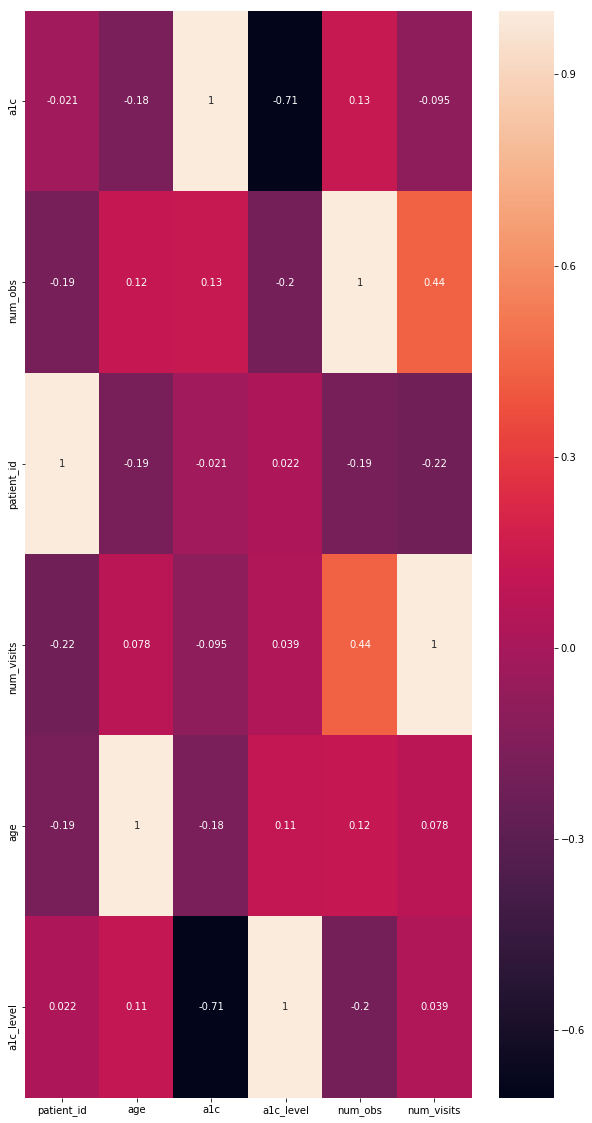

In [77]:
plt.figure(figsize=(10,20))
# sns.heatmap(new_data.corr()[["a1c"]].sort_values(by="a1c",ascending=False), annot=True)
sns.heatmap(new_data.corr().sort_values(by="a1c",ascending=False), annot=True)

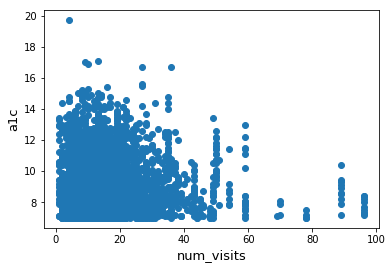

In [78]:
fig,ax=plt.subplots()
ax.scatter(x=new_data_aligned_no_dupes["num_visits"], y=new_data_aligned_no_dupes["a1c"])
plt.ylabel('a1c', fontsize=13)
plt.xlabel('num_visits', fontsize=13)
plt.show()

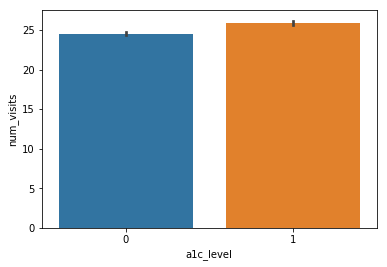

In [79]:
sns.barplot(x=new_data["a1c_level"],y=new_data['num_visits'])

In [80]:
new_data.groupby("num_visits")["a1c"].agg([np.mean,np.std]).sort_values(by="mean", ascending=False)

,mean,std
num_visits,,
50,10.785391,0.991796
35,10.525067,2.079987
1,9.955882,2.115340
24,9.706114,1.720569
4,9.633002,2.232612
27,9.615588,2.496270
19,9.499963,1.969831
34,9.439245,1.555423
38,9.375000,1.172083


In [81]:
new_data["num_visits"].median()

21.0

In [82]:
new_data["num_visits"].mean()

25.109019582519412

In [83]:
new_data["num_visits"]

0        10
1        10
2        10
3        10
4        10
         ..
61938     5
61939     5
61940     5
61941     5
61942     5
Name: num_visits, Length: 61943, dtype: int64

<Figure size 7200x14400 with 0 Axes>

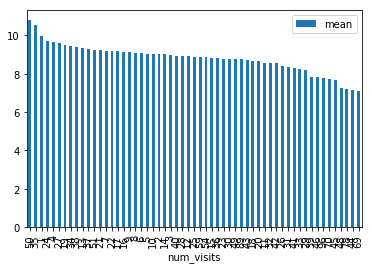

In [84]:
plt.figure(figsize=(100,200))
x = new_data.groupby("num_visits")["a1c"].agg([np.mean]).sort_values(by="mean", ascending=False).plot(kind = 'bar')
ax.set_title('Num visits by a1c', size = 0);
ax.set_ylabel('Average a1c', size = 20);
ax.set_xlabel('Avg visits', size = 20);
ax.tick_params(labelsize = 'large')

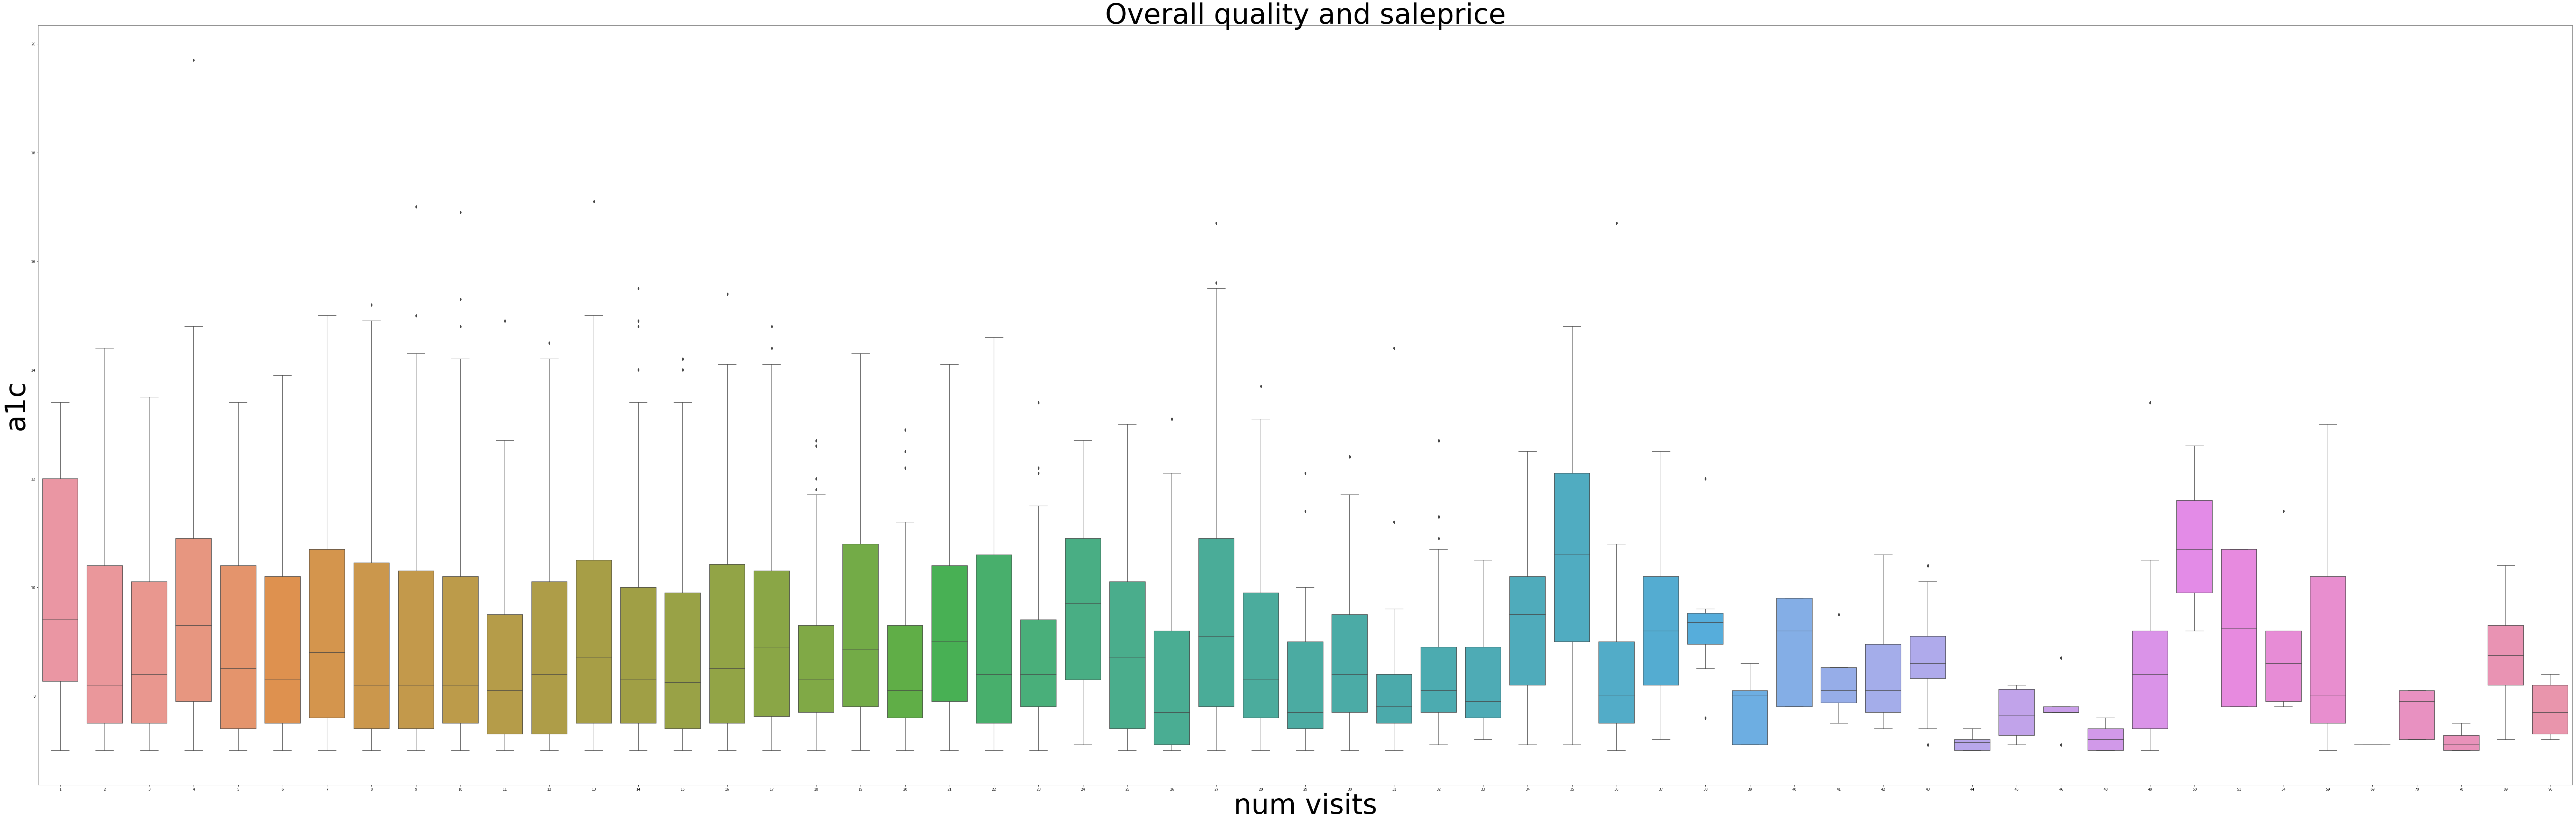

In [85]:
plt.figure(figsize=(130,40))
ax= sns.boxplot(new_data["num_visits"],new_data["a1c"])

ax.set_title('Overall quality and saleprice', size = 80);
ax.set_ylabel('a1c', size = 80);
ax.set_xlabel('num visits', size = 80);

In [86]:
sorted_sum= summary_and_visit_df.sort_values(by=["patient_id", "visit_date"])
#add column time in between visits 

In [87]:
sorted_sum.reset_index(inplace=True)

In [94]:
sorted_sum.head()

,patient_id,age,visit_date,summary,num_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10
3,72,56,2018-02-16,Uncontrolled DM,10
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10


In [95]:
# array_of_ids= np.unique(sorted_sum["patient_id"].values)

In [96]:
sorted_sum["time_between_visits"]=""

for i in range(sorted_sum.shape[0]):
    try:
        patient_sum= sorted_sum.loc[sorted_sum['patient_id'] == sorted_sum['patient_id'][i]]
        sorted_sum["time_between_visits"][i]= patient_sum["visit_date"][i+1] - patient_sum["visit_date"][i]
    except: 
        i= i+1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
sorted_sum.dtypes

patient_id                      int64
age                             int64
visit_date             datetime64[ns]
summary                        object
num_visits                     object
time_between_visits            object
dtype: object

In [98]:
# sorted_sum["time_between_visits"]=pd.to_datetime(sorted_sum["time_between_visits"])
# df['visit_date'] = pd.to_datetime(df['visit_date'])

In [99]:
new_data["num_obs"]=""

for i in range(new_data.shape[0]):
    try:
        mas=new_data.loc[new_data['patient_id'] == new_data['patient_id'][i]]
        new_data["num_obs"][i]= mas['obs_date'].nunique()
    except: 
        continue 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
sorted_sum.head(60)

,patient_id,age,visit_date,summary,num_visits,time_between_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10,9 days 00:00:00
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10,103 days 00:00:00
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10,100 days 00:00:00
3,72,56,2018-02-16,Uncontrolled DM,10,75 days 00:00:00
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10,149 days 00:00:00
5,72,56,2018-09-28,"Poorly controlled DM, osteoarthritis right thu...",10,112 days 00:00:00
6,72,56,2019-01-18,Diabetes follow up,10,119 days 00:00:00
7,72,56,2019-05-17,"f/u DM2, HLD",10,206 days 00:00:00
8,72,56,2019-12-09,"DM (A1c 7.1%), needs PPSV23/PCV13 vaccines",10,25 days 00:00:00
9,72,56,2020-01-03,"Worse a1c 8.2 from 7, no new meds, repeat lipids",10,


In [102]:
# sorted_sum.group_by("patient_id").agg
# sorted_sum.groupby("time_between_visits").mean()["patient_id"].sort_values(ascending=False)

# sorted_sum.groupby("patient_id")["time_between_visits"].agg([np.mean]).sort_values(by="mean", ascending=False)

In [103]:
#convert object to float 
def split_dates(dates_obj):
    if dates_obj:
        to_string=str(dates_obj)
        date_num= to_string.split()        
        return float(date_num[0])
    else: 
        return 
#     return date_num[0]

In [104]:
sorted_sum["time_between_visits"]= sorted_sum["time_between_visits"].map(split_dates)

In [105]:
sorted_sum.head(20)

,patient_id,age,visit_date,summary,num_visits,time_between_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10,9.0
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10,103.0
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10,100.0
3,72,56,2018-02-16,Uncontrolled DM,10,75.0
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10,149.0
5,72,56,2018-09-28,"Poorly controlled DM, osteoarthritis right thu...",10,112.0
6,72,56,2019-01-18,Diabetes follow up,10,119.0
7,72,56,2019-05-17,"f/u DM2, HLD",10,206.0
8,72,56,2019-12-09,"DM (A1c 7.1%), needs PPSV23/PCV13 vaccines",10,25.0
9,72,56,2020-01-03,"Worse a1c 8.2 from 7, no new meds, repeat lipids",10,NaN


In [106]:
sorted_sum.dropna(subset=["time_between_visits"],inplace=True)

In [107]:
values_time= sorted_sum.groupby(by='patient_id',as_index=False)['time_between_visits'].mean()
#how to tell if they are controlled or not controlled most of the time?
#patient id and average a1c level

In [108]:
values_time

,patient_id,time_between_visits
0,72,99.777778
1,254,20.584906
2,255,146.857143
3,304,54.500000
4,384,105.250000
...,...,...
1063,243204,7.666667
1064,243240,19.000000
1065,243548,21.333333
1066,243642,15.000000


In [109]:
sorted_sum.shape

(12798, 6)

In [110]:
# new_data["avg_time_between_visits"]=""

# for i in range(len(values_time)):
#     for x in range(sorted_sum.shape[0]):
#             if new_data["patient_id"][x]== values_time["patient_id"][i]:
#                 #index of where patient id is that value 
#                 new_data["avg_time_between_visits"][x]= values_time["time_between_visits"][i]
#                 print(values_time["time_between_visits"][i])

In [112]:
sorted_sum["avg_time_between_visits"]=""

for i in range(len(values_time)):
    for x in range(sorted_sum.shape[0]):
        try:
            if sorted_sum["patient_id"][x]== values_time["patient_id"][i]:
                #index of where patient id is that value 
                sorted_sum["avg_time_between_visits"][x]= values_time["time_between_visits"][i]
                print(values_time["time_between_visits"][i])
        except:
            continue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.5849056

81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307

35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
25.333333333333332
25.333333333333332
25.333333333333332
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
58.4
58.4
58.4
58.4
58.4
14.0
14.0
14.0
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81.75
91.45454545454545
91.45454545454545
91

79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.2258

115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688

42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.111111111111114
37.1111111

35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
35.266666666666666
124.0
124.0
124.0
124.0
124.0
124.0
124.0
190.5
190.5
99.11111111111111
99.11111111111111
99.11111111111111
99.11111111111111
99.11111111111111
99.11111111111111
99.11111111111111
99.11111111111111
99.11111111111111
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.416666666666664
44.41

55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
55.875
144.6
144.6
144.6
144.6
144.6
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
87.63636363636364
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
55.72222222222222
38.125
38.125
38.125
38.125
38.125
38.125
38.125
38.125
138.0
467.0
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.89655172413793
35.8965517241379

39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
39.88
11.0
11.0
11.0
11.0
89.9
89.9
89.9
89.9
89.9
89.9
89.9
89.9
89.9
89.9
116.375
116.375
116.375
116.375
116.375
116.375
116.375
116.375
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
52.15
56.375
56.375
56.375
56.375
56.375
56.375
56.375
56.375
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.941176470588236
30.94117

162.2
162.2
162.2
162.2
162.2
63.0
63.0
63.0
63.0
63.0
63.0
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
36.10344827586207
127.5
127.5
226.66666666666666
226.66666666666666
226.66666666666666
69.375
69.375
69.375
69.375
69.375
69.375
69.375
69.375
50.714285714285715
50.714285714285715
50.714285714285715
50.714285714285715
50.714285714285715
50.714285714285715
50.714285714285715
28.0
23.88888888888889
23.88888888888889
23.88888888888889
23.88888888888889
23.88888888888889
23.88888888888889
23.88888888888889
23.88888888888889
23.88888888

249.0
249.0
249.0
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
45.18181818181818
135.25
135.25
135.25
135.25
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
31.606060606060606
128.625
128.625
128.625
128.625
128.625
128.625
128.625
128.625
62.42857142857143
62.42857142857143
62.42857142857143
62.42857142

53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
53.529411764705884
126.625
126.625
126.625
126.625
126.625
126.625
126.625
126.625
203.0
203.0
203.0
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
78.91666666666667
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
46.333333333333336
44.705882352941174
44.705882352941174
44.705882352941174
44.705882352941174
44.705882352941174
44.705882352941174
44.705882352941174
44.705882352941174

59.5
59.5
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
55.125
106.5
106.5
106.5
106.5
106.5
106.5
175.6
175.6
175.6
175.6
175.6
125.0
125.0
125.0
125.0
125.0
125.0
125.0
125.0
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
28.583333333333332
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
55.05555555555556
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
51.45
140.16666666666666
140.16666666666666
140.16666666666666
140.16666666666666
140.166666666666

52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
52.85
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
42.857142857142854
42.857142857142854
42.857142857142854
42.857142857142854
42.857142857142854
42.857142857142854
42.857142857142854
61.714285714285715
61.714285714285715
61.714285714285715
61.714285714285715
61.714285714285715
61.714285714285715
61.714285714285715
173.75
173.75
173.75
173.75
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
63.46666666666667
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.57142857142857
48.571428

106.25
106.25
106.25
106.25
106.25
106.25
106.25
106.25
164.4
164.4
164.4
164.4
164.4
96.6
96.6
96.6
96.6
96.6
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
81.58333333333333
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
70.57142857142857
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
82.63636363636364
70.16666666666667
70.16666666666667
70.16666666666667
70.16666666666667
70.16666666666667
70.16666666666667
55.76470588235294
55.76470588235294
55.76470588235294
55.76470588235294
55.76470588235294
55.76470588235294
55.7647

89.375
89.375
89.375
89.375
89.375
89.375
89.375
89.375
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
65.6923076923077
77.0
77.0
77.0
77.0
77.0
77.0
77.0
77.0
77.0
77.0
77.0
77.0
14.0
62.0
81.0
81.0
81.0
81.0
81.0
29.0
29.0
29.0
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
91.72727272727273
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
64.85714285714286
77.28571428571429
77.28571428571429
77.28571428571429
77.28571428571429
77.28571428571429
77.28571428571429
77.28571428571429
77.28571428571429
77.28571428571429
7

22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
22.785714285714285
79.375
79.375
79.375
79.375
79.375
79.375
79.375
79.375
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
75.63636363636364
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.95238095238095
48.9523809523809

57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
57.529411764705884
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
67.93333333333334
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
84.08333333333333
44.125
44.125
44.125
44.125
44.125
44.125
44.125
44.125
148.16666666666666
148.16666666666666
148.16666666666666
148.16666666666666
148.16666666666666
148.16666666666666
42.875
42.875
42.875


91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
91.0909090909091
95.3
95.3
95.3
95.3
95.3
95.3
95.3
95.3
95.3
95.3
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
82.38461538461539
17.0
17.0
17.0
17.0
17.0
17.0
17.0
46.0
46.0
46.0
46.0
46.0
431.0
46.333333333333336
46.333333333333336
46.333333333333336
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
64.75
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
41.2
213.75
213.75
213.75
213.75
163.33333333333334
163.33333333333334
163.33333333333334
174.66666666666666
174.66666666666666
174.66666666666666
93.2
93.2
93.2
93.2
93.2
56.625
56.625
56.6

122.0
122.0
122.0
116.0
116.0
116.0
116.0
116.0
116.0
116.0
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
76.41666666666667
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
61.470588235294116
88.11111111111111
88.11111111111111
88.11111111111111
88.11111111111111
88.11111111111111
88.11111111111111
88.11111111111111
88.11111111111111
88.11111111111111
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63636363636363
33.63

In [143]:
sorted_sum["avg_time_between_visits"]=""

for x in range(sorted_sum.shape[0]):
    for i in range(len(values_time)):
        try:
            if sorted_sum["patient_id"][x]== values_time["patient_id"][i]:
                #index of where patient id is that value 
                sorted_sum["avg_time_between_visits"][x]= values_time["time_between_visits"][i]
                print(values_time["time_between_visits"][i])
        except:
            continue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
99.77777777777777
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.58490566037736
20.5849056

70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
81.5
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
30.735294117647058
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307692307692
55.92307

37.96153846153846
37.96153846153846
37.96153846153846
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
35.46666666666667
25.333333333333332
25.333333333333332
25.333333333333332
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
51.421052631578945
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
79.11111111111111
58.4
58.4
58.4
58.4
58.4
14.0
14.0
14.0
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81.75
81

46.95238095238095
46.95238095238095
46.95238095238095
46.95238095238095
46.95238095238095
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
79.0
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
42.40909090909091
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451612904
32.225806451

94.88888888888889
94.88888888888889
94.88888888888889
94.88888888888889
94.88888888888889
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
115.11111111111111
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
56.63157894736842
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.688311688311689
13.68831168831168

165.4
165.4
165.4
165.4
165.4
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
43.958333333333336
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
42.90909090909091
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
52.5
37.111111111111114

115.71428571428571
115.71428571428571
115.71428571428571
115.71428571428571
115.71428571428571
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
72.85714285714286
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
33.193548387096776
35.266666666666666
35.266666666666666
35.266666666666666
35.2666

25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
25.666666666666668
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.61111111111111
28.6111111

33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
33.81481481481482
101.375
101.375
101.375
101.375
101.375
101.375
101.375
101.375
85.875
85.875
85.875
85.875
85.875
85.875
85.875
85.875
141.6
141.6
141.6
141.6
141.6
84.22222222222223
84.22222222222223
84.22222222222223
84.22222222222223
84.22222222222223
84.22222222222223
84.22222222222223
84.22222222222223
84.22222222222223
69.0
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
50.05
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
71.33333333333333
46.0
46.0
58.5333333333

31.333333333333332
31.333333333333332
31.333333333333332
31.333333333333332
31.333333333333332
31.333333333333332
83.0
83.0
83.0
83.0
83.0
83.0
83.0
83.0
83.0
83.0
83.0
38.166666666666664
38.166666666666664
38.166666666666664
38.166666666666664
38.166666666666664
38.166666666666664
101.6
101.6
101.6
101.6
101.6
101.6
101.6
101.6
101.6
101.6
24.857142857142858
24.857142857142858
24.857142857142858
24.857142857142858
24.857142857142858
24.857142857142858
24.857142857142858
113.875
113.875
113.875
113.875
113.875
113.875
113.875
113.875
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.87096774193548
32.8709677

86.0909090909091
86.0909090909091
86.0909090909091
86.0909090909091
86.0909090909091
86.0909090909091
60.5
60.5
60.5
60.5
60.5
60.5
60.5
60.5
60.5
60.5
60.5
60.5
60.5
60.5
48.42857142857143
48.42857142857143
48.42857142857143
48.42857142857143
48.42857142857143
48.42857142857143
48.42857142857143
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
21.428571428571427
58.833333333333336
58.833333333333336

39.77777777777778
39.77777777777778
39.77777777777778
39.77777777777778
39.77777777777778
39.77777777777778
39.77777777777778
39.77777777777778
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
79.0909090909091
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
47.666666666666664
14.0
106.33333333333333
106.33333333333333
106.33333333333333
106.33333333333333
106.33333333333333
106.33333333333333
106.33333333333333
106.33333333333333
106.33333333333333
95.2
95.2
95.2
95.2
95.2
95.2
95.2
95.2
95.2
95.2
45.95238095238095
45.95238095238095
45.95238

11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842105263
11.494736842

50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
50.19047619047619
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
86.91666666666667
51.166666666666664
51.166666666666664
51.166666666666664
51.166666666666664
51.166666666666664
51.166666666666664
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
55.5
152.0
96.375
96.375
96.375
96.375
96.375
96.375
96.375
96.375
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
54.2
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
28.375
92.5
92.5
92.5
92.5
92.5
92.5
92.5
92.5
92.5
92.5
447.0
52.0625
52.0625


69.5
69.5
69.5
69.5
69.5
69.5
69.5
69.5
69.5
69.5
69.5
69.5
69.5
69.5
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
79.46153846153847
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333
95.33333333333333
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
35.13793103448276
48.545454545

67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
67.21428571428571
90.22222222222223
90.22222222222223
90.22222222222223
90.22222222222223
90.22222222222223
90.22222222222223
90.22222222222223
90.22222222222223
90.22222222222223
90.9
90.9
90.9
90.9
90.9
90.9
90.9
90.9
90.9
90.9
93.7
93.7
93.7
93.7
93.7
93.7
93.7
93.7
93.7
93.7
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
56.1578947368421
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
49.09090909090909
4

81.83333333333333
81.83333333333333
81.83333333333333
81.83333333333333
81.83333333333333
81.83333333333333
81.83333333333333
81.83333333333333
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
57.083333333333336
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
70.78571428571429
152.14285714285714
152.14285714285714
152.14285714285714
152.14285714285714
152.14285714285714
152.14285714285714
152.14285714285714
56.0
56.0
56.0
56.0
56.0
56.0
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.92857142857143
68.928571428571

28.25
28.25
28.25
28.25
28.25
28.25
28.25
28.25
28.25
28.25
28.25
28.25
28.25
28.25
137.6
137.6
137.6
137.6
137.6
130.14285714285714
130.14285714285714
130.14285714285714
130.14285714285714
130.14285714285714
130.14285714285714
130.14285714285714
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
79.66666666666667
110.5
110.5
110.5
110.5
110.5
110.5
111.66666666666667
111.66666666666667
111.66666666666667
111.66666666666667
111.66666666666667
111.66666666666667
74.83333333333333
74.83333333333333
74.83333333333333
74.83333333333333
74.83333333333333
74.83333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
72.53333333333333
142.57142

49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
49.36842105263158
28.875
28.875
28.875
28.875
28.875
28.875
28.875
28.875
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.9375
28.7
28.7
28.7
28.7
28.7
28.7
28.7
28.7
28.7
28.7
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
69.92307692307692
88.5
88.5
88.5
88.5
88.5
88.5
88.5
88.5
88.5
88.5
88.5
88.5
75.66666666666667
75.66666666666667
75.66666666666667
81.08333333333333
81.08333333333333
81

44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
44.608695652173914
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
82.0
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
64.84615384615384
149.0
149.0
149.0
149.0
93.0
93.0
93.0
93.0
93.0
93.0
142.8
142.8
142.8
142.8
142.8
180.66666666666666
180.66666666666666
180.66666666666666
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.25
37.

109.11111111111111
109.11111111111111
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
48.2
54.333333333333336
54.333333333333336
54.333333333333336
54.333333333333336
54.333333333333336
54.333333333333336
27.0
27.0
27.0
27.0
27.0
27.0
27.0
27.0
27.0
78.42857142857143
78.42857142857143
78.42857142857143
78.42857142857143
78.42857142857143
78.42857142857143
78.42857142857143
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
44.22727272727273
47.0
47.0
47.0
47.0
47.0
47.0
68.83333333333333
68.83333333333333
68.83333333333333
68.83333333333333
68.83333333333333
68.83333333333333
46.375
46.375
46.375
46.375
46.375
46.375
4

54.25
54.25
54.25
42.6
42.6
42.6
42.6
42.6
19.333333333333332
19.333333333333332
19.333333333333332
19.333333333333332
19.333333333333332
19.333333333333332
80.55555555555556
80.55555555555556
80.55555555555556
80.55555555555556
80.55555555555556
80.55555555555556
80.55555555555556
80.55555555555556
80.55555555555556
89.25
89.25
89.25
89.25
9.8
9.8
9.8
9.8
9.8
70.22222222222223
70.22222222222223
70.22222222222223
70.22222222222223
70.22222222222223
70.22222222222223
70.22222222222223
70.22222222222223
70.22222222222223
46.0
46.0
46.0
46.0
46.0
46.0
46.0
46.0
46.0
46.0
46.0
13.0
12.875
12.875
12.875
12.875
12.875
12.875
12.875
12.875
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
38.857142857142854
95.4
95.4
95.4
95.4
95.4
64.0
64.0
64.0
64.0
64.0
64.0
64.0
51.888888888888886
51.88888888888

In [145]:
sorted_sum.to_csv("../data/ss.csv")
#merge on id 

In [146]:
sorted_sum=pd.read_csv("../data/ss.csv")

In [147]:
sorted_sum.isnull().sum()

Unnamed: 0                  0
patient_id                  0
age                         0
visit_date                  0
summary                    11
num_visits                  0
time_between_visits         0
avg_time_between_visits     0
dtype: int64

In [148]:
sorted_sum.drop(columns=["Unnamed: 0"],inplace=True)

In [124]:
# new_sorted= sorted_sum.merge(date_a1c_df, how='inner', on=["patient_id"], left_on=None, right_on=None,
#          left_index=False, right_index=False, sort=True,
#          suffixes=('_x', '_y'), copy=True, indicator=False,
#          validate=None)

In [151]:
sorted_sum.tail()

,patient_id,age,visit_date,summary,num_visits,time_between_visits,avg_time_between_visits
12793,243642,54,2020-01-13,"right ear fullness and hearing loss, new HTN, ...",2,15.0,15.00
12794,243644,58,2019-11-20,"establish care, new diabetic on lantus and met...",5,7.0,12.75
12795,243644,58,2019-11-27,Diabetes ref letter,5,13.0,12.75
12796,243644,58,2019-12-10,"lost meds, f/u on DM, HTN",5,1.0,12.75
12797,243644,58,2019-12-11,"f/u DM, HTN, HLD, flu and TDap given",5,30.0,12.75


In [125]:
date_a1c_df.to_csv("../data/dataa1c.csv")

In [117]:
date_a1c_df.head()

,patient_id,age,obs_date,a1c,a1c_level,num_obs
0,72,56,2017-07-21,8.1,0,6
1,72,56,2019-01-19,7.6,1,6
2,72,56,2018-02-08,8.3,0,6
3,72,56,2017-10-20,7.7,1,6
4,72,56,2019-06-08,7.1,1,6


In [126]:
new_sorted.to_csv("../data/new_sorted.csv")

In [137]:
new_sorted.set_index('patient_id')

,age_x,visit_date,summary,num_visits,time_between_visits,avg_time_between_visits,age_y,obs_date,a1c,a1c_level,num_obs
patient_id,,,,,,,,,,,
72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778,56,2017-07-21,8.1,0,6
72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778,56,2019-01-19,7.6,1,6
72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778,56,2018-02-08,8.3,0,6
72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778,56,2017-10-20,7.7,1,6
72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778,56,2019-06-08,7.1,1,6
...,...,...,...,...,...,...,...,...,...,...,...
243644,58,2019-11-27,Diabetes ref letter,5,13.0,NaN,58,2019-12-03,12.2,0,2
243644,58,2019-12-10,"lost meds, f/u on DM, HTN",5,1.0,NaN,58,2019-11-20,13.4,0,2
243644,58,2019-12-10,"lost meds, f/u on DM, HTN",5,1.0,NaN,58,2019-12-03,12.2,0,2


In [138]:
new_sorted.drop_duplicates(inplace=True)

In [139]:
new_sorted.shape

(56963, 12)

In [123]:
sorted_sum.head()

,patient_id,age,visit_date,summary,num_visits,time_between_visits,avg_time_between_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10,103.0,99.777778
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10,100.0,99.777778
3,72,56,2018-02-16,Uncontrolled DM,10,75.0,99.777778
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10,149.0,99.777778


In [154]:
avg_a1c= date_a1c_df.groupby('patient_id',as_index=False)['a1c'].mean()

In [155]:
avg_a1c

,patient_id,a1c
0,72,7.833333
1,254,8.842857
2,255,10.233333
3,304,7.000000
4,384,8.500000
...,...,...
1094,243240,7.100000
1095,243410,7.300000
1096,243548,10.600000
1097,243642,7.500000


In [156]:
sorted_sum["avg_a1c"]=""

for x in range(sorted_sum.shape[0]):
    for i in range(len(avg_a1c)):
        try:
            if sorted_sum["patient_id"][x]== avg_a1c["patient_id"][i]:
                #index of where patient id is that value 
                sorted_sum["avg_a1c"][x]= avg_a1c["a1c"][i]
                print(avg_a1c["a1c"][i])
        except:
            continue 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


7.833333333333333
7.833333333333333
7.833333333333333
7.833333333333333
7.833333333333333
7.833333333333333
7.833333333333333
7.833333333333333
7.833333333333333
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.842857142857145
8.84285714

9.314285714285715
9.314285714285715
9.314285714285715
9.314285714285715
9.314285714285715
9.314285714285715
9.314285714285715
9.314285714285715
9.314285714285715
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
11.274999999999999
7.6
7.6
7.6
7.4
7.4
7.4
7.4
7.4
7.4
7.4
7.4
7.4
7.4
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
8.85
7.8
7.8
7.8
7.8
7.8
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.499999999999998
9.49

7.75
7.75
7.75
7.75
7.75
7.75
7.75
7.75
7.75
7.75
7.75
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.9
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
8.8
8.8
8.8
8.8
8.8
10.55
10.55
7.066666666666666
7.066666666666666
7.066666666666666
7.066666666666666
7.066666666666666
7.066666666666666
7.066666666666666
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.683333333333332
9.3
9.3
9.3
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.949999999999999
7.3
7.3
7.3

8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.75
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
8.149999999999999
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
7.25
13.6
13.6
13.6
13.6
13.6
13.6
13.6
10.5
10.5
10.5
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
7.3500000000000005
9.3
9.3
9.3
9.3
9.3
9.3
9.3
9.3
7.8
7.8
7.442857142857143
7.442857142857143
7.442857142857143
7.442857142857143
7.442857142857143
7.442857142857143

7.25
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
8.139999999999999
7.4
7.4
7.4
7.8
7.8
7.8
7.8
7.8
7.8
9.9
9.9
9.9
9.2
9.2
9.2
9.2
9.025
9.025
9.025
9.025
9.025
9.025
9.025
9.025
9.025
9.025
9.025
9.025
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
11.75
11.75
11.75
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
8.42
7.033333333333334
7.033333333333334
7.033333333333334
11.171428571428573
11.171428571428573
11.171428571428573
11.171428571428573
11.171428571428573
11.171428571428573
11.171428571428573
11.171428571428573
11.171428571428573
11.17142

7.333333333333333
7.333333333333333
7.333333333333333
7.333333333333333
7.333333333333333
7.333333333333333
7.333333333333333
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
8.25
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
11.257142857142856
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
8.083333333333332
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
9.52
7.279999999999999
7.279999999999999
7.279999999999999
7.279999999999999
7.279999999999999
7.279999999999999
7.279999999999999
7.279999999999999
7.2799999999999

9.955555555555556
7.4
7.4
7.4
7.4
7.4
7.4
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
8.333333333333334
9.833333333333334
9.833333333333334
9.833333333333334
9.833333333333334
9.833333333333334
9.833333333333334
9.833333333333334
9.833333333333334
9.833333333333334
9.833333333333334
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.875
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
7.433333333333334
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.787500000000001
9.78750000

7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
7.871428571428572
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
9.819999999999999
7.05
7.05
7.05
7.05
7.05
7.05
7.05
7.05
7.05
7.05
7.05
9.3
9.3
9.3
9.3
9.3
9.3
7.3
7.3
7.3
7.3
7.3
7.3
7.3
7.3
7.3
7.3
7.3
7.3
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.10909090909091
10.109090

7.539999999999999
7.9
7.9
7.9
7.9
7.9
9.825
9.825
9.825
9.825
10.399999999999999
10.399999999999999
10.399999999999999
10.399999999999999
10.399999999999999
10.399999999999999
7.8
7.8
7.8
8.84
8.84
8.84
8.84
8.84
8.84
8.84
8.84
8.84
8.84
8.84
8.84
8.84
8.84
9.275
9.275
9.275
9.275
9.275
9.275
9.275
9.275
9.275
9.275
9.275
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.700000000000001
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
9.116666666666665
10.5
10.5


7.7124999999999995
7.7124999999999995
7.7124999999999995
7.7124999999999995
7.7124999999999995
7.7124999999999995
7.7124999999999995
7.7124999999999995
7.7124999999999995
7.7124999999999995
7.0
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.342857142857143
10.850000000000001
10.850000000000001
10.850000000000001
10.850000000000001
10.850000000000001
10.850000000000001
10.85000

7.55
7.55
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
8.92
7.1
7.1
7.1
7.1
7.1
9.1
9.1
9.1
9.1
9.1
9.32
9.32
9.32
9.32
9.32
9.32
9.32
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
8.014285714285714
7.1
7.1
7.1
7.1
7.1
7.1
7.1
7.1
7.1
7.1
8.2
8.2
8.2
8.2
8.2
8.2
8.2
8.2
7.775
7.775
7.775
7.775
7.775
7.775
7.775
7.775
7.775
7.775
7.775
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
8.385714285714284
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7.575
7

11.933333333333332
11.933333333333332
11.933333333333332
11.933333333333332
11.933333333333332
11.933333333333332
11.933333333333332
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
7.7749999999999995
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
10.571428571428571
9.22
9.22
9.22
9.22
9.22
9.22
9.22
9.22
9.22
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.649999999999999
8.6

9.266666666666666
9.266666666666666
9.266666666666666
9.266666666666666
9.266666666666666
8.5
8.5
8.5
8.5
8.7
8.7
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.049999999999999
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
9.325000000000001
11.3
11.3
11.3
11.3
11.3
11.600000000000001
11.600000000000001
11.600000000000001
11.600000000000001
9.442857142857145
9.442857142857145
9.442857142857145
9.442857142857145
9.442857142857145
9.442857142857145
9.442857142857145
9.442857142857145
9.442857142857145
9.442857142857145
8.775
7.45
7.45
7.45
7.45
7.45
7.45
7.45
7.45
7.45
7.45
7.15
7.15
7.15
7.15
7.15
7.15
7.15
7.15
7.1
7

9.614285714285716
9.614285714285716
9.614285714285716
9.614285714285716
9.614285714285716
9.614285714285716
9.614285714285716
7.1
7.1
7.1
7.1
7.1
7.1
7.1
7.1
7.1
7.1
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.319999999999999
11.6
11.6
11.6
11.6
11.6
11.6
11.6
11.6
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
7.85
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333333334
7.933333333

8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
8.133333333333335
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.659999999999999
7.275
7.275
7.275
7.275
7.275
7.275
7.275
7.275
7.275
7.275
7.833333333333333
7.833333333333333
7.833333333333333
7.83

10.833333333333334
10.833333333333334
10.833333333333334
10.833333333333334
10.833333333333334
10.833333333333334
10.833333333333334
10.833333333333334
13.0
13.0
7.2
7.2
7.2
7.2
7.2
7.7
8.2
8.2
8.2
8.2
8.2
8.2
8.2
8.2
8.2
7.8
7.8
7.8
7.8
7.5
7.5
7.5
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
9.100000000000001
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
8.4
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
9.059999999999999
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7
7.7


10.663636363636364
10.663636363636364
10.663636363636364
10.663636363636364
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.8
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.825
7.4
7.4
7.4
7.4
7.4
7.4
9.5
9.5
9.5
9.5
9.5
9.5
9.5
9.5
9.5
9.7
9.7
9.7
9.7
9.7
9.7
9.7
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.912500000000001
8.0
8.0
8.0
8.0
8.0
8.0
10.7
10.7
10.7
10.7
10.7
10.7
9.55
9.55
9.55
9.55
9.55
9.55
9.55
9.55
7.4
7.4
7.4
7.4
8.166666666666666
8.166666666666666
8.166666666666666
8.166666666666666
8.166666666666666
8.166666666666666
8.166666666666666
8.166666666666666
8.166666666666666
8.1666666666

8.475
8.4
8.4
8.4
8.4
8.4
9.4
9.4
9.4
9.4
9.4
9.4
9.4
8.95
8.95
8.95
8.95
8.95
8.95
8.25
8.25
8.25
8.25
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
10.350000000000001
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
12.866666666666667
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
8.7
7.4
7.4
7.4
9.5
9.5
9.5
9.5
9.5
9.5
10.774999999999999
10.774999999999999
10.774999999999999
10.774999999999999
10.774999999999999
10.774999999999999
10.774999999999999
10.774999999999999
10.774999999999999
1

In [ ]:
date_a1c_df.head()

In [157]:
sorted_sum.head()

,patient_id,age,visit_date,summary,num_visits,time_between_visits,avg_time_between_visits,avg_a1c
0,72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778,7.83333
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10,103.0,99.777778,7.83333
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10,100.0,99.777778,7.83333
3,72,56,2018-02-16,Uncontrolled DM,10,75.0,99.777778,7.83333
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10,149.0,99.777778,7.83333


In [ ]:
# groupy= date_a1c_df.groupby(by='patient_id',as_index=False)['a1c'].mean()

In [158]:
sorted_sum.to_csv("../data/sorted_sum_data.csv")

In [159]:
df= pd.read_csv("../data/sorted_sum_data.csv")

In [162]:
df.head()

,Unnamed: 0,patient_id,age,visit_date,summary,num_visits,time_between_visits,avg_time_between_visits,avg_a1c
0,0,72,56,2017-07-19,"followup diabetes, med refill",10,9.0,99.777778,7.833333
1,1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10,103.0,99.777778,7.833333
2,2,72,56,2017-11-08,DM and dyslipidemia follow-up,10,100.0,99.777778,7.833333
3,3,72,56,2018-02-16,Uncontrolled DM,10,75.0,99.777778,7.833333
4,4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10,149.0,99.777778,7.833333


In [163]:
df.drop(columns=["Unnamed: 0"],inplace=True)

In [164]:
new_df = df[['patient_id', 'age',"num_visits","avg_time_between_visits","avg_a1c"]].copy()

(1068, 5)

In [167]:
new_df.drop_duplicates(inplace=True)

In [169]:
new_df.head()

,patient_id,age,num_visits,avg_time_between_visits,avg_a1c
0,72,56,10,99.777778,7.833333
9,254,64,54,20.584906,8.842857
62,255,64,8,146.857143,10.233333
69,304,70,5,54.500000,7.000000
73,384,66,9,105.250000,8.500000


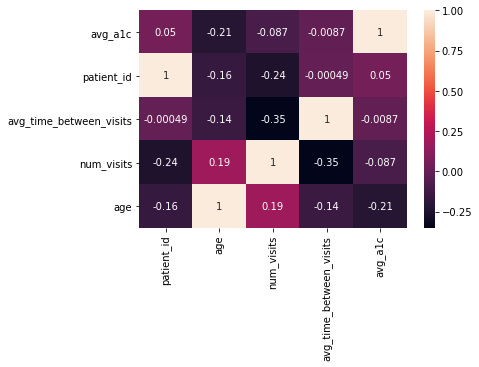

In [172]:
sns.heatmap(new_df.corr().sort_values(by="avg_a1c",ascending=False), annot=True)

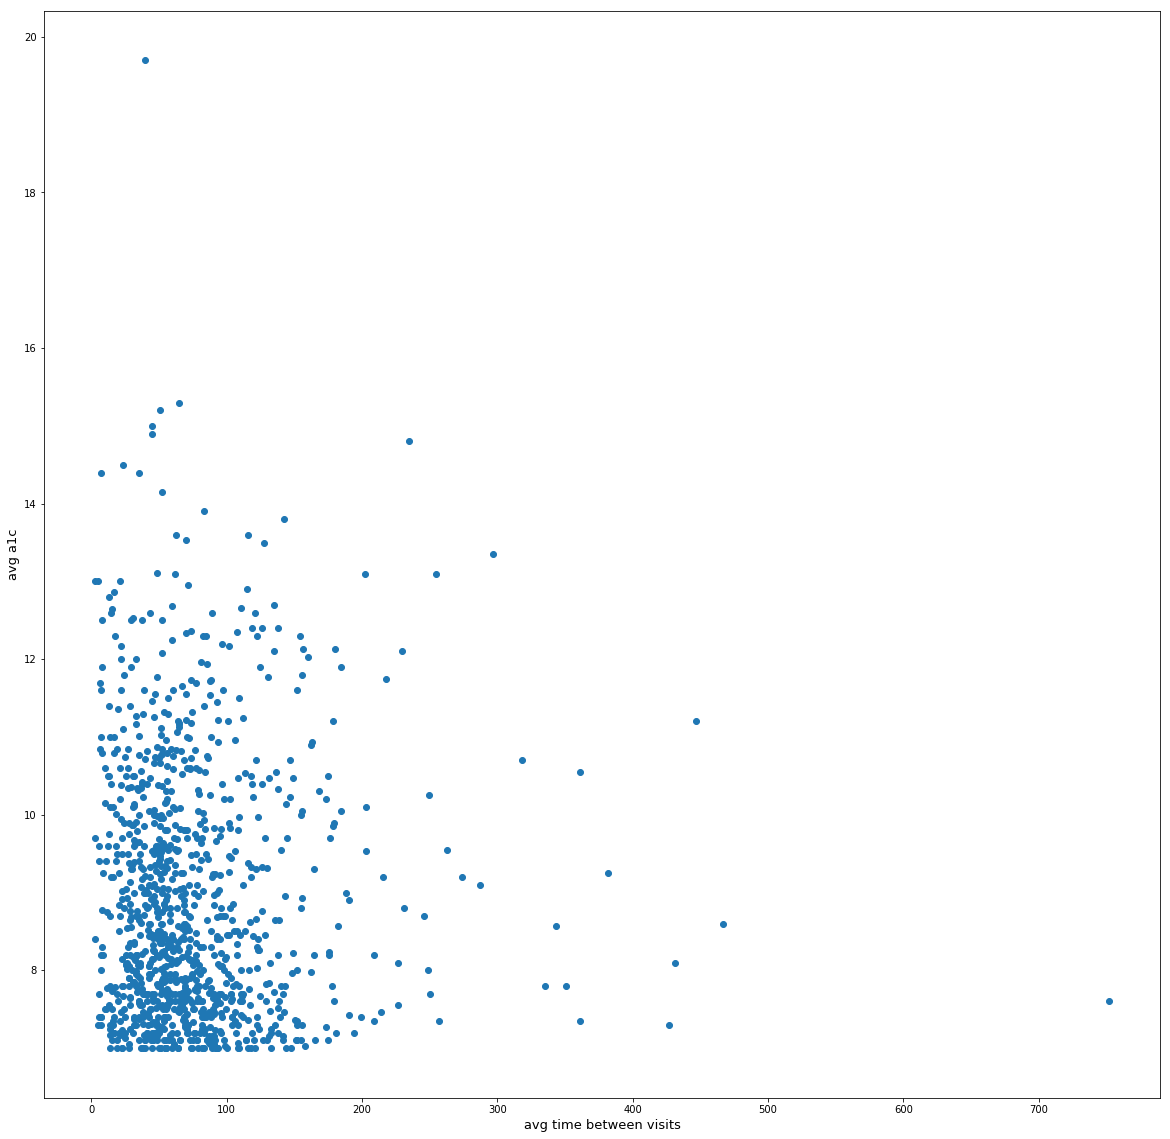

In [183]:
fig,ax=plt.subplots(figsize=(20,20))
ax.scatter(x=new_df["avg_time_between_visits"], y=new_df["avg_a1c"])
plt.ylabel('avg a1c', fontsize=13)
plt.xlabel('avg time between visits', fontsize=13)
plt.show()

In [189]:
new_df.head()

,patient_id,age,num_visits,avg_time_between_visits,avg_a1c,control_level
0,72,56,10,99.777778,7.833333,1
1,254,64,54,20.584906,8.842857,
2,255,64,8,146.857143,10.233333,
3,304,70,5,54.500000,7.000000,
4,384,66,9,105.250000,8.500000,


In [186]:
new_df.reset_index(inplace=True)

In [188]:
new_df.drop(columns=["index"],inplace=True)

In [190]:
new_df["control_level"]=""

for i in range(new_df.shape[0]):
    if new_df["avg_a1c"][i] <=8:
        new_df["control_level"][i]= 1
    else: new_df["control_level"][i]=0
        #1 is controlled

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [198]:
date_a1c_df.shape

(3617, 6)

In [251]:
date_a1c_df.isnull().sum()

patient_id    0
age           0
obs_date      0
a1c           0
a1c_level     0
num_obs       0
dtype: int64

In [256]:
date_a1c_df["num_obs"]

0        6
1        6
2        6
3        6
4        6
        ..
61926    1
61927    1
61931    1
61933    2
61934    2
Name: num_obs, Length: 3617, dtype: object

In [258]:
new_df.head(10)

,patient_id,age,num_visits,avg_time_between_visits,avg_a1c,control_level,num_obs
0,72,56,10,99.777778,7.833333,1,6
1,254,64,54,20.584906,8.842857,0,
2,255,64,8,146.857143,10.233333,0,
3,304,70,5,54.500000,7.000000,1,
4,384,66,9,105.250000,8.500000,0,
5,386,53,50,22.142857,10.381818,0,
6,521,71,2,100.000000,7.000000,1,
7,763,38,12,77.545455,10.600000,0,
8,914,81,51,20.800000,9.250000,0,
9,936,73,17,52.937500,7.900000,1,


In [261]:
date_a1c_df.reset_index(inplace=True)

In [263]:
date_a1c_df.drop(columns=["index"])

,patient_id,age,obs_date,a1c,a1c_level,num_obs
0,72,56,2017-07-21,8.1,0,6
1,72,56,2019-01-19,7.6,1,6
2,72,56,2018-02-08,8.3,0,6
3,72,56,2017-10-20,7.7,1,6
4,72,56,2019-06-08,7.1,1,6
...,...,...,...,...,...,...
3612,243410,59,2019-11-27,7.3,1,1
3613,243548,53,2019-11-06,10.6,0,1
3614,243642,54,2020-01-14,7.5,1,1
3615,243644,58,2019-11-20,13.4,0,2


In [264]:
new_df["num_obs"]=""

for x in range(date_a1c_df.shape[0]):
    for i in range(new_df.shape[0]):
            if date_a1c_df["patient_id"][x]== new_df["patient_id"][i]:
                #index of where patient id is that value 
                new_df["num_obs"][i]= date_a1c_df["num_obs"][x]
                print(date_a1c_df["num_obs"][x])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


6
6
6
6
6
6
7
7
7
7
7
7
7
2
2
2
1
4
4
4
4
11
11
11
11
11
11
11
11
11
11
11
1
1
2
2
6
6
6
6
6
6
7
7
7
7
7
7
7
1
6
6
6
6
6
6
11
11
11
11
11
11
11
11
11
11
11
7
7
7
7
7
7
7
2
2
2
2
1
9
9
9
9
9
9
9
9
9
1
3
3
3
5
5
5
5
5
4
4
4
4
3
3
3
1
6
6
6
6
6
6
2
2
1
6
6
6
6
6
6
1
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
2
2
1
4
4
4
4
1
8
8
8
8
8
8
8
8
8
1
5
5
5
5
5
6
6
6
6
6
6
1
3
3
3
2
2
1
6
6
6
6
6
6
4
4
4
4
4
4
4
4
5
5
5
5
5
8
8
8
8
8
8
8
8
1
4
4
4
4
5
5
5
5
5
5
5
5
5
5
2
2
1
2
2
1
1
5
5
5
5
5
10
10
10
10
10
10
10
10
10
10
4
4
4
4
6
6
6
6
6
6
1
2
2
1
3
3
3
7
7
7
7
7
7
7
2
2
1
4
4
4
4
6
6
6
6
6
6
1
1
5
5
5
5
5
4
4
4
4
3
3
3
1
1
1
1
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
10
10
10
10
10
10
10
10
10
10
2
2
6
6
6
6
6
6
1
2
2
1
2
2
1
1
4
4
4
4
2
2
2
2
3
3
3
6
6
6
6
6
6
1
2
2
1
3
3
3
8
8
8
8
8
8
8
8
10
10
10
10
10
10
10
10
10
10
3
3
3
1
4
4
4
4
3
3
3
1
5
5
5
5
5
5
2
2
5
5
5
5
5
1
1
9
9
9
9
9
9
9
9
9
6
6
6
6
6
6
2
2
9
9
9
9
9
9
9
9
9
7
7
7
7
7
7
7
7
7
7
7
7
7
7
2
2
3
3
3
3
3
3
1
7
7
7
7
7
7
7
7
2
2
2
2
5
5
5
5
5
4


In [265]:
new_df.tail()

,patient_id,age,num_visits,avg_time_between_visits,avg_a1c,control_level,num_obs
1063,243204,65,4,7.666667,12.5,0,1
1064,243240,41,3,19.000000,7.1,1,1
1065,243548,53,4,21.333333,10.6,0,1
1066,243642,54,2,15.000000,7.5,1,1
1067,243644,58,5,12.750000,12.8,0,2


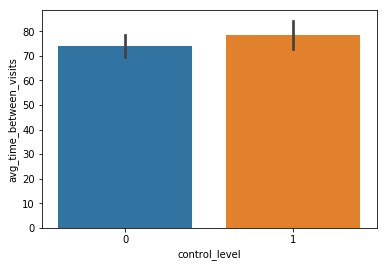

In [192]:
sns.barplot(x=new_df["control_level"],y=new_df['avg_time_between_visits'])

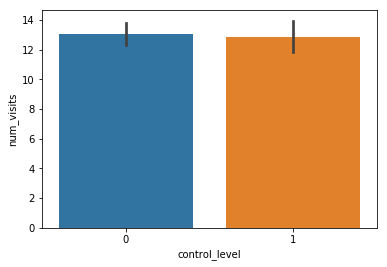

In [193]:
sns.barplot(x=new_df["control_level"],y=new_df['num_visits'])

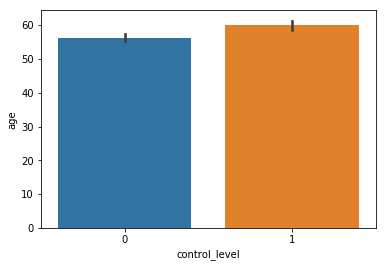

In [203]:
sns.barplot(x=new_df["control_level"],y=new_df['age'])

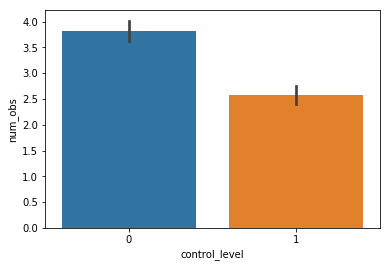

In [270]:
sns.barplot(x=new_df["control_level"],y=new_df['num_obs'])

In [285]:
new_df["num_obs"]= new_df["num_obs"].map(convert)

In [284]:
new_df["control_level"]=new_df["control_level"].map(convert)

In [286]:
new_df.dtypes

patient_id                   int64
age                          int64
num_visits                   int64
avg_time_between_visits    float64
avg_a1c                    float64
control_level              float64
num_obs                    float64
dtype: object

# Modelling

In [287]:
new_df["control_level"].value_counts(normalize=True)

0.0    0.600187
1.0    0.399813
Name: control_level, dtype: float64

Simple model first: linear regression 
    #feature engineering?

# Linear Regression 

In [289]:
features=['avg_time_between_visits',"age","num_visits","num_obs"]
X = new_df[features] # X = what we use to predict y
y = new_df['avg_a1c'] # y = what we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [290]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Score on the training set: {lr.score(X_train, y_train)}')
print(f'Score on the test set: {lr.score(X_test, y_test)}')

Score on the training set: 0.07655737557026987
Score on the test set: 0.08884825793752982


In [228]:
#just average time between visits NOT GOOD INDICATOR 
#Score on the training set: 0.0021031223272715005
#Score on the test set: -0.005781819824666412

# Second simple model: logistic regression 

In [299]:
features=['avg_time_between_visits',"age","num_visits","num_obs"]
X = new_df[features]
y = new_df['control_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=39)

In [300]:
y_train

839     1.0
673     1.0
671     0.0
307     0.0
431     0.0
       ... 
227     0.0
582     1.0
916     1.0
1065    0.0
105     0.0
Name: control_level, Length: 801, dtype: float64

In [301]:
y.value_counts(normalize=True)

0.0    0.600187
1.0    0.399813
Name: control_level, dtype: float64

In [302]:
logreg = LogisticRegression()

In [303]:
logreg.fit(X_train, y_train)

# print(f'Score on the training set: {logreg.score(X_train, y_train)}')
# print(f'Score on the test set: {logreg.score(X_test, y_test)}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [304]:
print(f'Score on the training set: {logreg.score(X_train, y_train)}')
print(f'Score on the test set: {logreg.score(X_test, y_test)}')

Score on the training set: 0.6754057428214731
Score on the test set: 0.6367041198501873


In [311]:
print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Intercept: [-1.38070144]
Logistic Regression Coefficient: [[ 0.00251095  0.02228041  0.04501979 -0.36030959]]


In [312]:
np.exp(logreg.coef_)

array([[1.00251411, 1.02253047, 1.04604856, 0.69746037]])

As average time between visits increases by 1, someone is about 1.002 times as likely to be controlled.
As age increases by 1, someone is about 1.002 times as likely to be controlled.
As num visits increases by 1, someone is about 1.04 times as likely to be controlled.


['avg_time_between_visits',"age","num_visits","num_obs"]

In [313]:
print(f'Logistic Regression predicted probabilities: \n{logreg.predict_proba(X_train.head())}')

Logistic Regression predicted probabilities: 
[[0.54766851 0.45233149]
 [0.33315842 0.66684158]
 [0.70990075 0.29009925]
 [0.60146732 0.39853268]
 [0.6903967  0.3096033 ]]


In [305]:

from sklearn.ensemble import RandomForestClassifier

In [307]:
rf = RandomForestClassifier()

In [308]:
rf.fit(X_train, y_train)

print(f'Score on the training set: {rf.score(X_train, y_train)}')
print(f'Score on the test set: {rf.score(X_test, y_test)}')

Score on the training set: 0.9712858926342073
Score on the test set: 0.602996254681648


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [309]:
from sklearn.neighbors import KNeighborsClassifier

In [310]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print(f'Score on the training set: {knn.score(X_train, y_train)}')
print(f'Score on the test set: {knn.score(X_test, y_test)}')

Score on the training set: 0.7203495630461922
Score on the test set: 0.5468164794007491
